In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.metrics import auc
from sklearn.metrics import f1_score

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections

from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
import scikitplot as skplt
warnings.filterwarnings("ignore")

In [3]:
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")

In [4]:
PPP_Energy = PPP_data[PPP_data.sector == "Energy"]
PPP_ICT = PPP_data[PPP_data.sector == "ICT"]
PPP_Transport = PPP_data[PPP_data.sector == "Transport"]
PPP_Water = PPP_data[PPP_data.sector == "Water and sewerage"]

In [5]:
print("shape of energy sector: ", PPP_Energy.shape)
print("shape of ICT sector: ", PPP_ICT.shape)
print("shape of transport sector: ", PPP_Transport.shape)
print("shape of water sector: ", PPP_Water.shape)

shape of energy sector:  (3599, 44)
shape of ICT sector:  (134, 44)
shape of transport sector:  (1893, 44)
shape of water sector:  (1052, 44)


In [6]:
PPP_Water.status_n.value_counts()

Active        936
Concluded      55
Cancelled      49
Distressed     12
Name: status_n, dtype: int64

In [7]:
#1.PPI database
PPP_data = PPP_Transport
#add experience
country_experience = PPP_data.groupby(['countrycode', 'IY']).size().reset_index().sort_values(['countrycode', 'IY'])
country_experience.columns = ['countrycode', 'IY', 'experience']
unique_country = country_experience.countrycode.unique()
years = np.arange(1990, 2020)

for country in unique_country:
    for year in years:
        if year not in country_experience.loc[country_experience.countrycode==country, 'IY'].values:
            country_experience = country_experience.append({'countrycode': country, 'IY': year, 'experience': 0}, ignore_index=True)

country_experience = country_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_experience.shape[0]))
country_experience['cum_experience'] = country_experience.groupby('countrycode')['experience'].cumsum()
country_experience.drop(columns=['experience'], inplace=True)

country_experience['shifted_country_experience_1'] = country_experience.groupby('countrycode')['cum_experience'].shift(1).fillna(method='bfill')
country_experience.drop(columns=['cum_experience'], inplace=True)

In [9]:
country_experience

,countrycode,IY,shifted_country_experience_1
0,AGO,1990,0.0
1,AGO,1991,0.0
2,AGO,1992,0.0
3,AGO,1993,0.0
4,AGO,1994,0.0
...,...,...,...
2545,ZWE,2015,2.0
2546,ZWE,2016,2.0
2547,ZWE,2017,2.0
2548,ZWE,2018,2.0


In [8]:
country_sector_experience = PPP_data.groupby(['countrycode', 'IY', 'ssector']).size().reset_index().sort_values(['countrycode', 'IY'])
country_sector_experience.columns = ['countrycode', 'IY', 'ssector', 'ssector_experience']
unique_sector_country = country_sector_experience.countrycode.unique()
unique_sector = country_sector_experience.ssector.unique()
years = np.arange(1990, 2020)

for country in unique_sector_country:
    for year in years:
        if year not in country_sector_experience.loc[country_sector_experience.countrycode==country, 'IY'].values:
            for sectors in unique_sector:
                country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                              'IY': year, 
                                                                              'ssector': sectors, 
                                                                              'ssector_experience': 0}, ignore_index=True)
        else:
            for sectors in unique_sector:
                if sectors not in country_sector_experience.loc[(country_sector_experience.countrycode==country) & (country_sector_experience.IY==year),
                                                                'ssector'].values:
                    country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                                  'IY': year, 
                                                                                  'ssector': sectors, 
                                                                                  'ssector_experience': 0}, ignore_index=True)

country_sector_experience = country_sector_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_sector_experience.shape[0]))
country_sector_experience['cum_ssector_experience'] = country_sector_experience.groupby(['countrycode', 'ssector'])['ssector_experience'].cumsum()
country_sector_experience.drop(columns=['ssector_experience'], inplace=True)

country_sector_experience['shifted_ssector_experience_1'] = country_sector_experience.groupby(['countrycode', 'ssector'])['cum_ssector_experience'].shift(1).fillna(method='bfill')
country_sector_experience.drop(columns=['cum_ssector_experience'], inplace=True)

In [10]:
country_sector_experience

,countrycode,IY,ssector,shifted_ssector_experience_1
0,AGO,1990,Seaports,0.0
1,AGO,1990,Airports,0.0
2,AGO,1990,Toll Roads,0.0
3,AGO,1990,Railroads,0.0
4,AGO,1991,Seaports,0.0
...,...,...,...,...
10195,ZWE,2018,Railroads,1.0
10196,ZWE,2019,Seaports,0.0
10197,ZWE,2019,Airports,0.0
10198,ZWE,2019,Toll Roads,1.0


In [11]:
PPP_data = PPP_data.merge(country_experience,
                          left_on=['countrycode', 'IY'],
                          right_on=['countrycode', 'IY'],
                          how='left')

In [12]:
PPP_data.shape

(1893, 45)

In [13]:
PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'ssector'],
                          right_on=['countrycode', 'IY', 'ssector'],
                          how='left')

In [14]:
PPP_data.shape

(1893, 46)

In [15]:
PPP_data.loc[:, 'PCO'] = PPP_data['PCO'].str.replace('\n', '') 
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'sponsor_number'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[2])
PPP_data.sponsor_number = PPP_data.sponsor_number.replace('', np.nan)

PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])

PPP_data.foreign_country = PPP_data.foreign_country.replace('N', 'No')
PPP_data.loc[(PPP_data.foreign_country!='No') & (~PPP_data.foreign_country.isnull()), 'foreign_country'] = 'Yes'

In [16]:
PPP_data.shape

(1893, 48)

In [17]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)   
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)
    dataset[i][name] = dataset[i].groupby('countrycode')[name].shift(1).fillna(method='bfill')

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [18]:
PPP_data.shape

(1893, 63)

In [19]:
PPP_data.head(5)

,IY,country,Region,income,IDA,FCY,type,stype,status_n,sector,...,electric_consumption,domestic_credit_to_private,imports_as_GDP,exports_as_GDP,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability
0,1990,Argentina,LAC,Upper middle income,Non-IDA,1/9/1990,Brownfield,"Rehabilitate, operate, and transfer",Active,Transport,...,1320.35657186199,39.7174950191489,6.57938879331971,13.0584089085641,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
1,1990,Mexico,LAC,Upper middle income,Non-IDA,1/11/1990,Greenfield project,"Build, operate, and transfer",Active,Transport,...,1232.47927061236,21.2478867299859,19.1974507744512,19.1321993029959,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
2,1990,Thailand,EAP,Upper middle income,Non-IDA,1/12/1990,Management and lease contract,Lease contract,Active,Transport,...,614.948290786396,106.362551068585,37.4854054733393,34.9215280475186,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
3,1990,Mexico,LAC,Upper middle income,Non-IDA,1/12/1990,Greenfield project,"Build, operate, and transfer",Active,Transport,...,1232.47927061236,21.2478867299859,19.1974507744512,19.1321993029959,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
4,1990,Mexico,LAC,Upper middle income,Non-IDA,1/3/1990,Greenfield project,"Build, operate, and transfer",Active,Transport,...,1232.47927061236,21.2478867299859,19.1974507744512,19.1321993029959,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854


In [20]:
#copy data out.
data = PPP_data.copy()
data.drop(columns=['country',
                   'regionname',                   
                   'region',
                   'adminregionname',
                   'Description',
                   'FCY',
                   'bid_crit',
                   'incomelevelname',
                   'lendingtypename',
                   'TIGS',
                   'PCO',
                   'sector',
                   'shareborder',
                   'GDP',
                   'population',
                   'investment_real',
                   'realphysicalassets',
                   'income'], inplace=True)

data.replace('..', np.nan, inplace=True)

data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability',
               'shifted_country_experience_1',
               'shifted_ssector_experience_1',
               'period',
               'CPI2019',
               'bordercountries', 
               'private', 
               'physical', 
               'period',
               'investment', 
               'pcapacity',
               'sponsor_number',
               'IY']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'ssector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'BS',
                 'lendingtype'
                 'adminregion',
                 'foreign_country']
ordinal_value = ['incomelevel']

for float_column in float_value:
    data[float_column] = data[float_column].astype(float)

In [21]:
data.shape

(1893, 45)

In [22]:
data.head(10)

,IY,Region,IDA,type,stype,status_n,ssector,Segment,period,GGC,...,electric_consumption,domestic_credit_to_private,imports_as_GDP,exports_as_GDP,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability
0,1990.0,LAC,Non-IDA,Brownfield,"Rehabilitate, operate, and transfer",success,Toll Roads,Highway,28.0,NaN,...,1320.356572,39.717495,6.579389,13.058409,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
1,1990.0,LAC,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,30.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
2,1990.0,EAP,Non-IDA,Management and lease contract,Lease contract,success,Seaports,Runway and terminal,27.0,NaN,...,614.948291,106.362551,37.485405,34.921528,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
3,1990.0,LAC,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,60.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
4,1990.0,LAC,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,30.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
5,1990.0,LAC,Non-IDA,Brownfield,"Build, rehabilitate, operate, and transfer",success,Toll Roads,Highway,31.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
6,1990.0,EAP,Non-IDA,Management and lease contract,Lease contract,success,Seaports,Runway and terminal,27.0,NaN,...,614.948291,106.362551,37.485405,34.921528,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
7,1990.0,EAP,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,33.0,NaN,...,487.373173,77.133290,13.261366,11.844329,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
8,1990.0,LAC,Non-IDA,Brownfield,"Build, rehabilitate, operate, and transfer",success,Toll Roads,Highway,25.0,State/Provincial,...,1320.356572,39.717495,6.579389,13.058409,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
9,1990.0,SAR,Non-IDA,Brownfield,"Build, rehabilitate, operate, and transfer",success,Toll Roads,Highway,NaN,NaN,...,257.039736,26.589814,8.152002,7.016130,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854


In [23]:
# BS (Bilateral Support) replace with NO and Yes, 
data.loc[(data.BS!='No') & (~data.BS.isnull()), 'BS'] = 'Yes'
#private convert to categorical data.
#physical, investment, pcapacity will be converted to np.log
to_log = ['physical', 'investment', 'pcapacity']
for column in to_log:
    data[column] = np.log(data[column] + 0.01)

In [24]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X = X.drop(columns='IY')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [25]:
print("shape of train dataset: ", X_train.shape)
print("shape of test dataset: ", X_test.shape)
print("imbalance rate of train dataset: ", y_train.sum()/y_train.shape)
print("imbalance rate of test dataset: ", y_test.sum()/y_test.shape)
print("failure projects of train dataset: ", y_train.sum())
print("failure projects of test dataset: ", y_test.sum())

shape of train dataset:  (1419, 43)
shape of test dataset:  (474, 43)
imbalance rate of train dataset:  [0.05990134]
imbalance rate of test dataset:  [0.06118143]
failure projects of train dataset:  85
failure projects of test dataset:  29


In [26]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

#imputing numerical value
class FillNumericalNa(BaseEstimator, TransformerMixin):
    def __init__(self, column, group_list):
        print('......... init() called.')
        self.column = column
        self.group_list = group_list
        
    def fit(self, X, y=None):
        print('......... fit() called.')
        self.mean = X.groupby(self.group_list)[self.column].agg(pd.Series.mean).to_frame().reset_index()
        self.column_mean = X[self.column].mean()
        return self
    
    def transform(self, X, y=None):
        print('.......... transform () called.')
        X_ = X.copy()
        X_result = X_.reset_index().merge(self.mean, on=self.group_list, how='left').set_index('index')
        for i in X_[np.isnan(X_[self.column])].index:
            X_.loc[i, self.column] = X_result.loc[i, self.column + '_y']
        X_[self.column].fillna(self.column_mean, inplace=True)
        return X_

# imputing categorical value
class FillCategoricalNa(BaseEstimator, TransformerMixin):
    def __init__(self, column, group_list):
        print('......... init() called.')
        self.column = column
        self.group_list = group_list
        
    def fit(self, X, y=None):
        print('......... fit() called.')
        self.mode = X.groupby(self.group_list)[self.column].agg(pd.Series.mode).to_frame().reset_index()
        
        for index, row in self.mode.iterrows():
            if type(row[self.column]) == np.ndarray:
                self.mode.loc[index, self.column] = X[self.column].mode()[0]
                
        self.column_mode = X[self.column].mode()[0]
        return self
    
    def transform(self, X, y=None):
        print('.......... transform () called.')
        X_ = X.copy()
        X_result = X_.reset_index().merge(self.mode, on=self.group_list, how='left').set_index('index')
        for i in X_[X_[self.column].isnull()].index:
            X_.loc[i, self.column] = X_result.loc[i, self.column + '_y'] 
        X_[self.column].fillna(self.column_mode, inplace=True)
        return X_

#drop columns
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        print('......... init() called.')
        self.column = column
        
    def fit(self, X, y=None):
        print('......... fit() called.')
        return self
    
    def transform(self, X, y=None):
        print('.......... transform () called.')
        X_ = X.copy()
        X_.drop(columns=self.column, inplace=True)
        return X_
#get_dummies
from pandas.api.types import CategoricalDtype
class DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, min_frequency=1, dummy_na=True):
        print('......... init() called.')
        self.min_frequency = min_frequency
        self.dummy_na = dummy_na
        self.categories = dict()

    def fit(self, X, y=None):
        print('......... fit() called.')
        for col in X.select_dtypes(include=['object']).columns:
            counts = pd.value_counts(X[col])
            self.categories[col] = list(set(counts[counts >= self.min_frequency].index.tolist()))
        return self

    def transform(self, X, *_):
        print('.......... transform () called.')
        for col in X.select_dtypes(include=['object']).columns:
            X = X.astype({col: CategoricalDtype(self.categories[col], ordered=True)})
        ret = pd.get_dummies(X, drop_first=True, dummy_na=self.dummy_na)
        return ret

In [28]:
numerical_index = X.select_dtypes(include=['int64', 'float64']).columns
t = [('num', RobustScaler(), numerical_index)]
col_transform = ColumnTransformer(remainder='passthrough', transformers=t)
#smote
smote = SMOTE(sampling_strategy='minority',random_state=0)
#undersampling
undersample = RandomUnderSampler(random_state=0)

In [47]:
pca = PCA(n_components=60, random_state=13)
pipe = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                    ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                    ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                    ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                    ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                    ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                    ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                    ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                    ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                    ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                    ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                    ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                    ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                    ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                    ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                    ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                    ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                    ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                    ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                    ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                    ('dropcolumn1', DropColumn(['countrycode'])),
                    ('encoding', DummyEncoder())
                    ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [48]:
X_new = pipe.fit_transform(X_train, y_train)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

In [50]:
scaler = RobustScaler()
numeric_column = X_new.columns[X_new.dtypes == 'float64']
X_new[numeric_column] = scaler.fit_transform(X_new[numeric_column])

In [52]:
XX = pca.fit_transform(X_new)

In [54]:
pca.explained_variance_ratio_

array([9.84148065e-01, 1.46709081e-02, 2.61151865e-04, 1.88606446e-04,
       1.32318479e-04, 9.44485061e-05, 8.22456550e-05, 5.13697069e-05,
       4.72264887e-05, 4.12307737e-05, 3.36290884e-05, 2.87710390e-05,
       2.35002565e-05, 2.01876938e-05, 1.70675466e-05, 1.63937333e-05,
       1.42088840e-05, 1.36836410e-05, 1.23560287e-05, 1.07804294e-05,
       8.65370777e-06, 7.58984157e-06, 7.32854712e-06, 6.99391420e-06,
       6.07149506e-06, 5.42889049e-06, 5.00463638e-06, 4.96095221e-06,
       4.29373016e-06, 3.10357134e-06, 2.83223326e-06, 2.67636642e-06,
       2.28526485e-06, 2.26371209e-06, 2.01874740e-06, 1.97919770e-06,
       1.82012812e-06, 1.48010942e-06, 1.38573608e-06, 1.33455752e-06,
       1.25278108e-06, 1.10988595e-06, 9.05915721e-07, 8.51635004e-07,
       8.10086056e-07, 7.99485637e-07, 7.57908554e-07, 6.93423250e-07,
       6.61613821e-07, 5.78706542e-07, 5.00872751e-07, 4.79997307e-07,
       4.19800337e-07, 3.56695386e-07, 3.46440225e-07, 3.30507471e-07,
      

In [57]:
len(pca.components_[0])

93

In [185]:
pca_rf = PCA(n_components=60, random_state=13)
pipe_rf_smote = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                    ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                    ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                    ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                    ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                    ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                    ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                    ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                    ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                    ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                    ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                    ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                    ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                    ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                    ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                    ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                    ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                    ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                    ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                    ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                    ('dropcolumn1', DropColumn(['countrycode'])),
                    ('encoding', DummyEncoder()),
                    ('scaler', col_transform),
                    ('smote', smote),
                    ('pca', pca_rf),
                    ('clf', RandomForestClassifier(random_state=1))
                    ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [168]:
pipe_rf_under = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                    ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                    ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                    ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                    ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                    ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                    ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                    ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                    ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                    ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                    ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                    ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                    ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                    ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                    ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                    ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                    ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                    ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                    ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                    ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                    ('dropcolumn1', DropColumn(['countrycode'])),
                    ('encoding', DummyEncoder()),
                    ('scaler', col_transform),
                    ('smote', undersample),
                    ('pca', pca_rf),
                    ('clf', RandomForestClassifier(random_state=1))
                    ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [186]:
pipe_rf_smote.fit(X_train, y_train)
result_rf_smote = pipe_rf_smote.predict_proba(X_test)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

In [194]:
pipe_rf_under.fit(X_train, y_train)
result_rf_under = pipe_rf_under.predict_proba(X_test)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

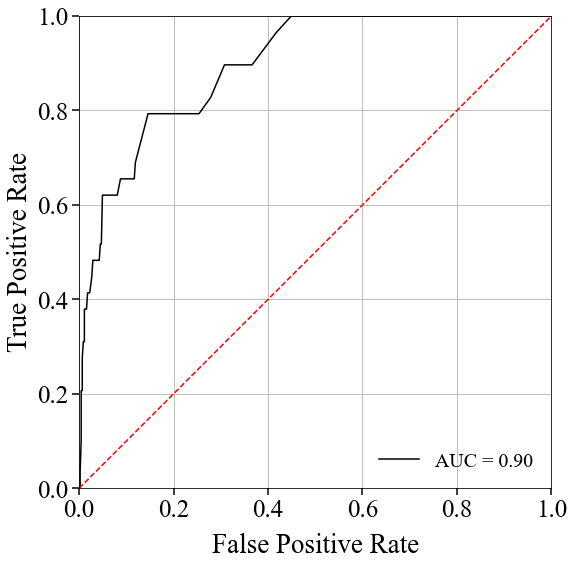

In [187]:
plot_roc(y_test, result_rf_smote[:,1])

In [204]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, result_rf_smote[:,1])
auc(lr_recall, lr_precision)

0.4316003236569226

In [207]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, result_rf_under[:,1])
auc(lr_recall, lr_precision)

0.37576264171567064

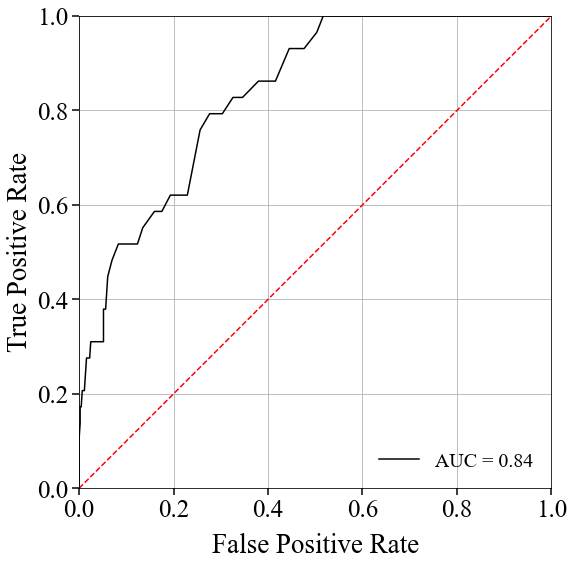

In [195]:
plot_roc(y_test, result_rf_under[:,1])

No handles with labels found to put in legend.


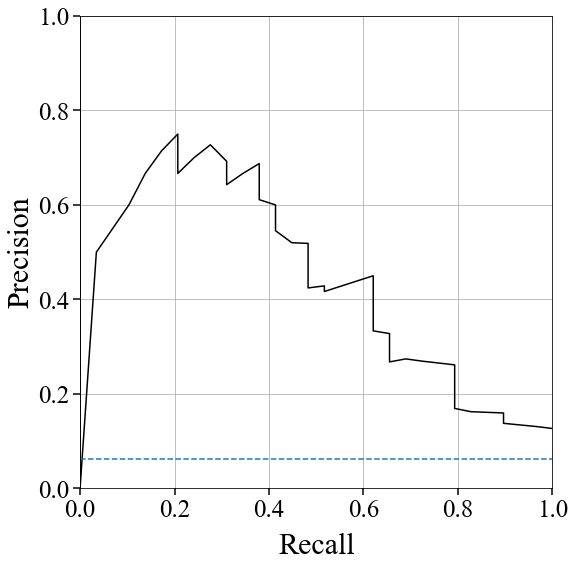

In [236]:
plot_recall_precision(y_test, result_rf_smote[:,1])

No handles with labels found to put in legend.


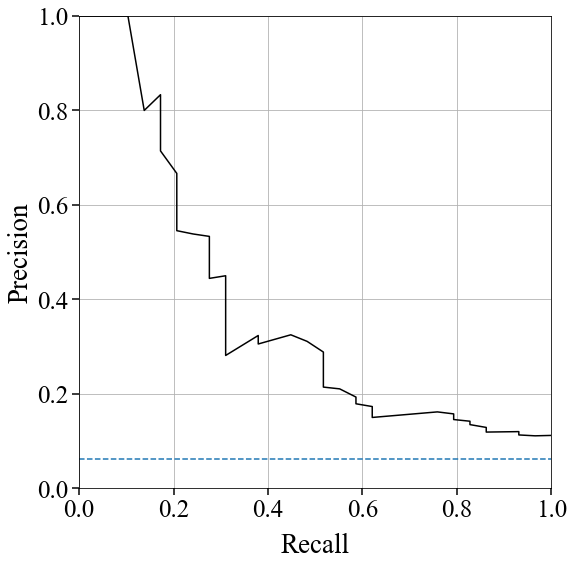

In [196]:
plot_recall_precision(y_test, result_rf_under[:,1])

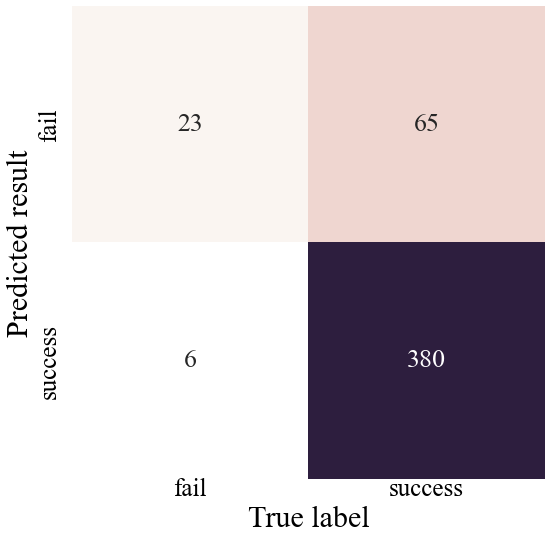

In [237]:
plot_cm(y_test, result_rf_smote[:, 1], 0.20)#50, 0.229; 40, 0.20, 25-71; 60, 0.20, 23-61; 80, 0.23, 20-43

In [208]:
pca_svm = PCA(n_components=50, random_state=123)
pipe_svm_smote = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                     ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                     ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                     ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                     ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                     ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                     ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                     ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                     ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                     ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                     ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                     ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                     ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                     ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                     ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                     ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                     ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                     ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                     ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                     ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                     ('dropcolumn1', DropColumn(['countrycode'])),
                     ('encoding', DummyEncoder()),
                     ('scaler', col_transform),
                     ('smote', smote),
                     ('pca', pca_svm),
                     ('model', svm.SVC(random_state=1, probability=True))
                     ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [209]:
pipe_svm_under = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                     ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                     ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                     ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                     ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                     ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                     ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                     ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                     ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                     ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                     ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                     ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                     ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                     ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                     ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                     ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                     ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                     ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                     ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                     ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                     ('dropcolumn1', DropColumn(['countrycode'])),
                     ('encoding', DummyEncoder()),
                     ('scaler', col_transform),
                     ('smote', undersample),
                     ('pca', pca_svm),
                     ('model', svm.SVC(random_state=1, probability=True))
                     ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [210]:
pipe_svm_smote.fit(X_train, y_train)
result_svm_smote = pipe_svm_smote.predict_proba(X_test)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

In [211]:
pipe_svm_under.fit(X_train, y_train)
result_svm_under = pipe_svm_under.predict_proba(X_test)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

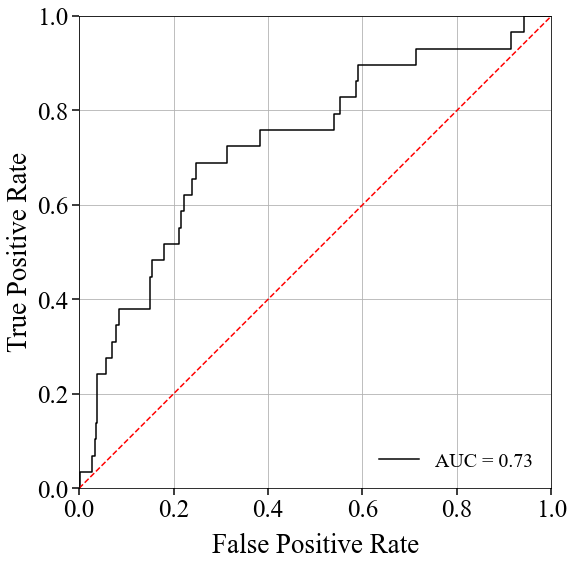

In [212]:
plot_roc(y_test, result_svm_smote[:,1])

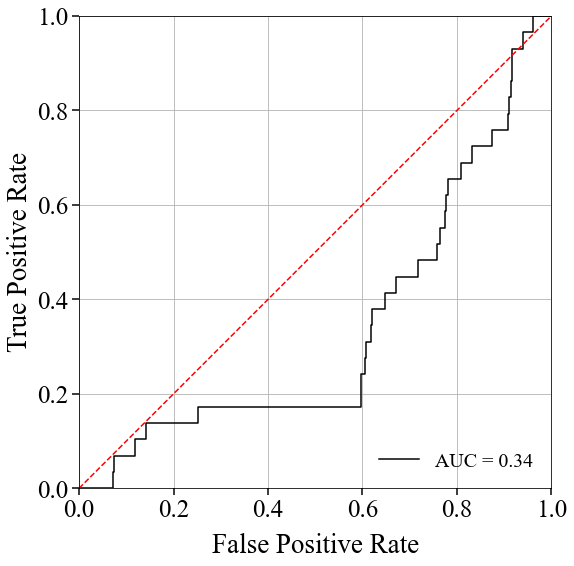

In [213]:
plot_roc(y_test, result_svm_under[:,1])

No handles with labels found to put in legend.


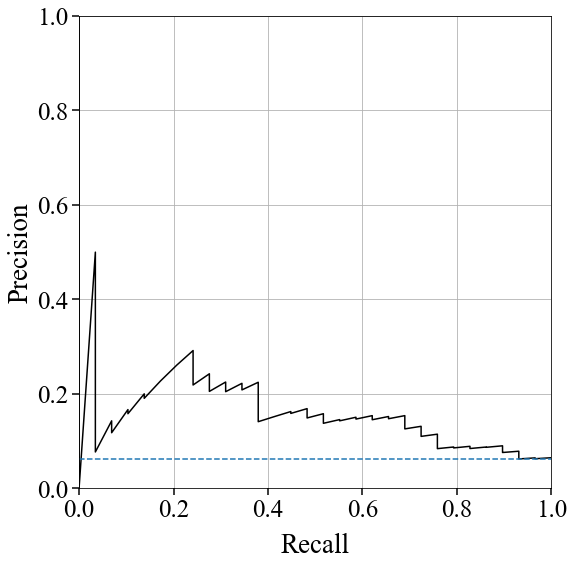

In [214]:
plot_recall_precision(y_test, result_svm_smote[:,1])

In [215]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, result_svm_under[:,1])
auc(svm_recall, svm_precision)

0.04410965857425685

In [216]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, result_svm_smote[:,1])
auc(svm_recall, svm_precision)

0.152961231776838

In [217]:
pca_lr = PCA(n_components=50, random_state=123)
pipe_lr_smote = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                     ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                     ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                     ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                     ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                     ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                     ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                     ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                     ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                     ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                     ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                     ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                     ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                     ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                     ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                     ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                     ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                     ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                     ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                     ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                     ('dropcolumn1', DropColumn(['countrycode'])),
                     ('encoding', DummyEncoder()),
                     ('scaler', col_transform),
                     ('smote', smote),
                     ('pca', pca_lr),
                     ('model', LogisticRegression(random_state=1))
                     ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [218]:
pipe_lr_under = Pipeline([('imputing1', FillNumericalNa('period', ['stype', 'Region', 'countrycode'])),
                     ('imputing2', FillNumericalNa('pcapacity', ['stype', 'Region', 'countrycode'])),
                     ('imputing3', FillNumericalNa('private', ['stype', 'ssector', 'countrycode'])),
                     ('imputing4', FillNumericalNa('physical', ['stype', 'ssector', 'countrycode'])),
                     ('imputing5', FillNumericalNa('investment', ['stype', 'Region', 'countrycode'])),
                     ('imputing6', FillNumericalNa('tax_as_GDP', ['Region'])),
                     ('imputing7', FillNumericalNa('real_effective_change', ['Region'])),
                     ('imputing8', FillNumericalNa('domestic_credit_to_private', ['Region'])),
                     ('imputing9', FillNumericalNa('rule_of_law', ['Region'])),
                     ('imputing10', FillNumericalNa('imports_as_GDP', ['Region'])),
                     ('imputing11', FillNumericalNa('exports_as_GDP', ['Region'])),
                     ('imputing12', FillNumericalNa('electric_consumption', ['Region'])),
                     ('imputing13', FillNumericalNa('sponsor_number', ['countrycode', 'ssector'])),
                     ('imputing14', FillCategoricalNa('GGC', ['countrycode', 'ssector'])),
                     ('imputing15', FillCategoricalNa('lendingtype', ['countrycode', 'ssector'])),
                     ('imputing16', FillCategoricalNa('PRS', ['countrycode', 'ssector'])),
                     ('imputing17', FillCategoricalNa('BS', ['countrycode', 'ssector'])),
                     ('imputing18', FillCategoricalNa('adminregion', ['Region'])),
                     ('imputing19', FillCategoricalNa('incomelevel', ['Region'])),
                     ('imputing20', FillCategoricalNa('foreign_country', ['countrycode', 'ssector'])),
                     ('dropcolumn1', DropColumn(['countrycode'])),
                     ('encoding', DummyEncoder()),
                     ('scaler', col_transform),
                     ('smote', undersample),
                     ('pca', pca_lr),
                     ('model', LogisticRegression(random_state=1))
                     ])

......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.
......... init() called.


In [219]:
pipe_lr_smote.fit(X_train, y_train)
result_lr_smote = pipe_lr_smote.predict_proba(X_test)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

In [220]:
pipe_lr_under.fit(X_train, y_train)
result_lr_under = pipe_lr_under.predict_proba(X_test)

......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () called.
......... fit() called.
.......... transform () 

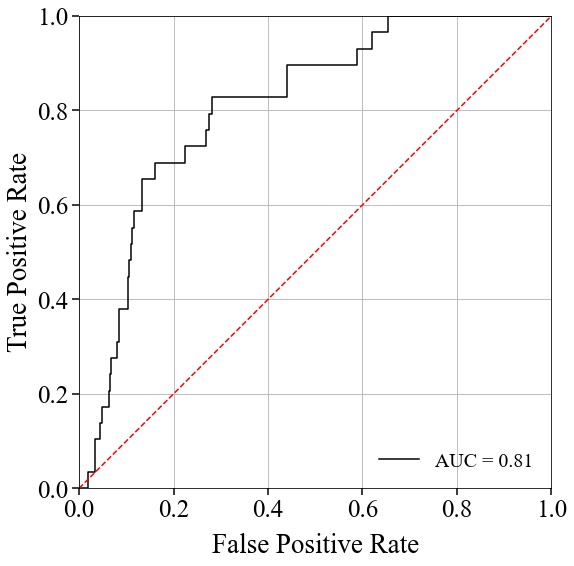

In [222]:
plot_roc(y_test, result_lr_smote[:,1])

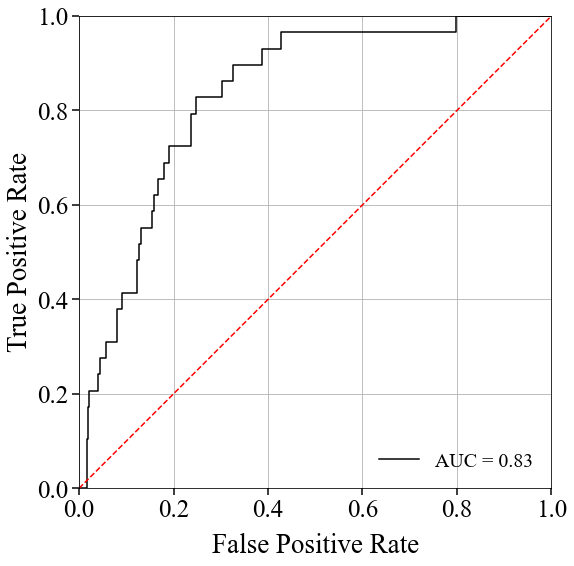

In [221]:
plot_roc(y_test, result_lr_under[:,1])

In [223]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, result_lr_smote[:,1])
auc(lr_recall, lr_precision)

0.1695382063748025

In [224]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, result_lr_under[:,1])
auc(lr_recall, lr_precision)

0.2043401926671123

In [235]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    ax.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    ax.set_xlabel("True Positive Rate", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("False Positive Rate", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(loc='lower right', frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.plot([0, 1], [0, 1],'r--')
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\ROC.png", dpi=1000)

def plot_recall_precision(y_true, y_pred):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--')
    ax.set_xlabel("Recall", fontsize=30, fontname='times new roman', labelpad=10)
    ax.set_ylabel("Precision", fontsize=30, fontname='times new roman', labelpad=4)
    ax.legend(frameon=False, prop={'family':'Times new roman', 'size':23})
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\precision-recall.png", dpi=1000)


def plot_cm(labels, predictions, p):
    cm = confusion_matrix(labels, predictions > p)
    new_cm = np.array([[0, 0], [0, 0]])
    new_cm[0, 0] = cm[1, 1]
    new_cm[0, 1] = cm[0, 1]
    new_cm[1, 0] = cm[1, 0]
    new_cm[1, 1] = cm[0, 0]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)  

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(new_cm, annot=True, fmt='.0f', cmap=cmap, annot_kws={"size":26, 'fontname': 'times new roman'}, cbar=False)

    
    plt.yticks([0.5,1.5], [ 'fail', 'success'],va='center')
    plt.xticks([0.5,1.5], [ 'fail', 'success'],va='center')
    
    ax.set_xlabel("True label", fontsize=30, fontname='times new roman')
    ax.set_ylabel("Predicted result", fontsize=30, fontname='times new roman')
    
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.tick_params(axis='both', length=0, labelsize=25, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\confusion matrix.png", dpi=1000)
    
    
def plot_threshold_graph(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score = 2*precision*recall/(recall + precision)
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision, 'k')
    plt.plot(thresholds, recall,'r')
    plt.plot(thresholds, f1_score, 'y')

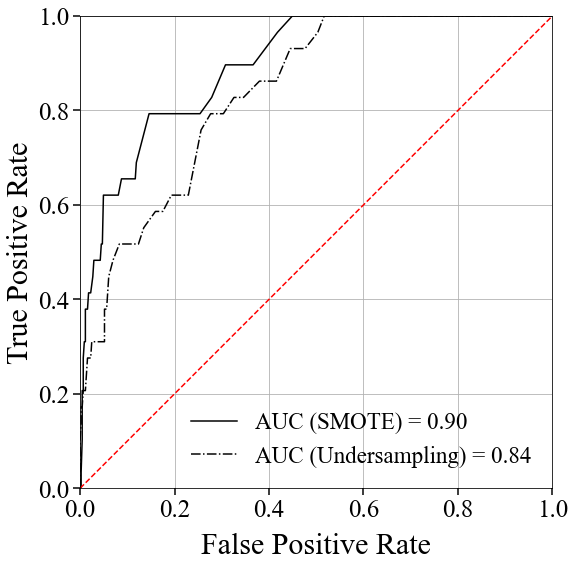

In [234]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, result_rf_smote[:, 1])
roc_auc1 = metrics.auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, result_rf_under[:, 1])
roc_auc2 = metrics.auc(fpr2, tpr2)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)   
ax.plot(fpr1, tpr1, 'k-', label = 'AUC (SMOTE) = %0.2f' % roc_auc1)
ax.plot(fpr2, tpr2, 'k-.', label = 'AUC (Undersampling) = %0.2f' % roc_auc2)
ax.set_xlabel("False Positive Rate", fontsize=30, fontname='times new roman', labelpad=10)
ax.set_ylabel("True Positive Rate", fontsize=30, fontname='times new roman', labelpad=4)
ax.legend(loc='lower right', frameon=False, prop={'family':'Times new roman', 'size':23})
ax.plot([0, 1], [0, 1],'r--')
ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.axis('square')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)